### 处理raw state

In [1]:
import numpy as np
raw_state = np.load(file='datasample/4-29/manual_16x3/anon_16_3_crowd/OD/180/raw_state.npy', allow_pickle=True)
raw_next_state = np.load(file='datasample/4-29/manual_16x3/anon_16_3_crowd/OD/180/raw_next_state.npy', allow_pickle=True)

In [6]:
raw_state[5][0]

[array([-0.51792415]),
 array([9.70421421]),
 array([18.30007119]),
 array([51.68437165]),
 array([49.86313742]),
 array([42.24207585]),
 array([39.28663725]),
 array([56.44181441]),
 array([47.77494941]),
 array([51.67837755]),
 array([44.42586482]),
 array([47.43797328]),
 array([50.95077641]),
 array([40.54102322]),
 array([44.31285466]),
 array([0.19540918]),
 array([-1.14198919])]

In [ ]:
def route_attention(raw_obs):
    

In [4]:
len(raw_state)

2172

In [5]:
len(raw_next_state)

2172

### 查看网络结构图

In [5]:
from tensorboardX import SummaryWriter
# writer = SummaryWriter('tensorboard/4-5/OD_graph/')
# 模型
import torch
from actor_critic.model import AttentionQ, OD_policy
Q_net = AttentionQ(8 + 1, 32)
P_net = OD_policy(16)
input_P = torch.rand([3, 16, 1])
input_Q = torch.rand([1, 9]), torch.rand([1, 9]), torch.rand([1, 9])
with SummaryWriter(comment='QNet') as w:
    w.add_graph(Q_net, input_Q)


/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [7]:
import hiddenlayer as h
import torch
from actor_critic.model import AttentionQ, OD_policy
Q_net = AttentionQ(8 + 1, 32)
input = torch.zeros([1, 9]), torch.zeros([1, 9]), torch.zeros([1, 9])
vis_graph = h.build_graph(Q_net, input)   # 获取绘制图像的对象
vis_graph.theme = h.graph.THEMES["blue"].copy()     # 指定主题颜色
vis_graph.save("demo1.png")   # 保存图像的路径

### 汇总datasample

In [ ]:
import numpy as np
dir_list = ['qdsac/datasample/4-4-2/manual_16x3/anon_16_3_crowd/OD/60', 'qdsac/datasample/4-3/manual_16x3/anon_16_3_crowd/OD/80']
state_batch = []
next_state_batch = []
action_batch = []
reward_batch = []
for name in dir_list:
    state_batch.append(np.load(file=name + '/state.npy'))
    next_state_batch.append(np.load(file=name + '/next_state.npy'))
    action_batch.append(np.load(file=name + '/action.npy'))
    reward_batch.append(np.load(file=name + '/reward.npy'))
state_batch = np.concatenate(state_batch)
next_state_batch = np.concatenate(next_state_batch)
action_batch = np.concatenate(action_batch)
reward_batch = np.concatenate(reward_batch)
print(len(state_batch))
print(state_batch.shape)

dir = 'datasample/4-4/hangzhou_4x4/hangzhou_flow/collect/'
if not os.path.isdir(dir):
    os.makedirs(dir)
buffer_size = len(state_batch)
np.save(dir + 'state.npy', state_batch)
np.save(dir + 'action.npy', action_batch)
np.save(dir + 'reward.npy', reward_batch)
np.save(dir + 'next_state.npy', next_state_batch)

### train OD_route

In [ ]:
from actor_critic.OD_agent import OD_agent
from actor_critic.route_attention import Route_Attention
from actor_critic.replay_memory import AgentReplayMemory
import numpy as np
dir_name = 'datasample/4-21/manual_16x3/anon_16_3_crowd/OD/180/'
state_batch = np.load(file=dir_name + 'state.npy')
next_state_batch = np.load(file=dir_name + 'next_state.npy')
action_batch = np.load(file=dir_name + 'action.npy')
reward_batch = np.load(file=dir_name + 'reward.npy')



: 

In [2]:
state_batch.shape

(1810, 3, 1)

In [ ]:
memory = AgentReplayMemory(2000, 3, state_dim=16)
memory.buffer['state'] = state_batch
memory.buffer['next_state'] = next_state_batch
memory.buffer['reward'] = reward_batch
memory.buffer['action'] = action_batch
memory.buffer['done'] = np.zeros((2000, 3, 1))
memory._size = len(state_batch)

In [4]:
import argparse
import gym
import torch.nn.functional as F
from world import World, Route
from torch.utils.tensorboard import SummaryWriter
import os
import json

parser = argparse.ArgumentParser(description="Base Actor-Critic Args")
parser.add_argument(
    "--gamma",
    type=float,
    default=0,
    metavar="G",
    help="discount factor for reward (default: 0.99)",
)
parser.add_argument(
    "--tau",
    type=float,
    default=0.125,
    metavar="G",
    help="target smoothing coefficient(τ) (default: 0.125)",
)
parser.add_argument(
    "--alpha",
    type=float,
    default=0,
    metavar="G",
    help="Temperature parameter α determines the relative importance of the entropy\
                    term against the reward (default: 0.2)",
)
parser.add_argument(
    "--lr",
    type=float,
    default=0.001,
    metavar="G",
    help="learning rate (default: 0.001)",
)
parser.add_argument(
    "--batch_size", type=int, default=32, metavar="N", help="batch size (default: 4)"
)
parser.add_argument(
    "--start_episodes", type=int, default=20, metavar="N", help="random sample before"
)
parser.add_argument(
    "--update_after", type=int, default=24, metavar="N", help="update parameters"
)
parser.add_argument(
    "--updates_per_step",
    type=int,
    default=10,
    metavar="N",
    help="model updates per simulator step (default: 1)",
)
parser.add_argument(
    "--target_update_interval",
    type=int,
    default=1,
    metavar="N",
    help="Value target update per no. of updates per step (default: 20)",
)
parser.add_argument(
    "--replay_size",
    type=int,
    default=2000,
    metavar="N",
    help="size of replay buffer (default: 2000)",
)
parser.add_argument(
    "--steps", type=int, default=6, help="number of steps (default: 3600)"
)
parser.add_argument(
    "--thread", type=int, default=8, help="number of threads (default: 8)"
)
parser.add_argument(
    "--num_routes", type=int, default=3, help="number of route choices (default: 3)"
)
parser.add_argument(
    "--action_interval",
    type=int,
    default=1800,
    help="how often agent make decisions (default: 120)",
)
parser.add_argument(
    "--episodes", type=int, default=200, help="training episodes (default: 1)"
)
parser.add_argument(
    "--embed_dim", type=int, default=8, help="training episodes (default: 1)"
)
parser.add_argument(
    "--att_dim", type=int, default=16, help="training episodes (default: 1)"
)
parser.add_argument(
    "--compare_dim", type=int, default=16, help="training episodes (default: 1)"
)
parser.add_argument("--config_file", type=str, help="path of config file")
parser.add_argument("--date", type=str, help="date of running")
args = parser.parse_args(args=["--config_file", "dataset/manual_16x3/config_undir.json", "--att_dim", 4, "--embed_dim", 1, "--compare_dim", 16])


world = World(args.config_file, thread_num=args.thread, args=args)
action_space = gym.spaces.Box(np.array([-1]), np.array([1]))
route_attention = Route_Attention(world, args)
agent = OD_agent(route_attention, args.compare_dim, args)

building world...
creating intersections...
intersections created.
parsing roads...
world built.


/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
from torch.utils.tensorboard import SummaryWriter
import torch
import os
writer = SummaryWriter('tensorboard/train_from_memory/OD/500')
dir_name = 'model/train_from_memory/OD/'
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)
for i in range(1500):
    critic_loss, policy_loss = agent.update_parameters(memory, memory._size)
    writer.add_scalar('local_critic_loss', critic_loss, i)
    writer.add_scalar('policy_loss', policy_loss, i)
    print(i,'|critic_loss:', critic_loss, '|policy_loss:', policy_loss)

    if i % 499 == 0 and i > 0:
        torch.save(agent.policy.state_dict(), dir_name + 'policy{}.pth'.format(i+1))
        torch.save(agent.critic.state_dict(), dir_name + 'critic{}.pth'.format(i+1))

/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/mnt/nas/home/cilab/WYH/qdsac/actor_critic/model.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Z = torch.mm(F.softmax(torch.mm(Q, K.t()) / self._out_features), V)
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/cilab/anaconda3/envs/RLP/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/tensorboard/summary/writer/event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(hea

0 |critic_loss: 321.1903991699219 |policy_loss: -57.63956069946289
1 |critic_loss: 295.0655822753906 |policy_loss: -57.33115005493164
2 |critic_loss: 321.59356689453125 |policy_loss: -57.345977783203125
3 |critic_loss: 320.83319091796875 |policy_loss: -57.88201141357422
4 |critic_loss: 295.6856689453125 |policy_loss: -58.28706359863281


KeyboardInterrupt: 

### 离线route

In [1]:
import numpy as np
dir_name = 'datasample/4-5/hangzhou_4x4/hangzhou_flow/route/180/'
state_batch = np.load(file=dir_name + 'state.npy')
next_state_batch = np.load(file=dir_name + 'next_state.npy')
action_batch = np.load(file=dir_name + 'action.npy')
reward_batch = np.load(file=dir_name + 'reward.npy')

In [6]:
positive_sample = [i for i in range(2000) if reward_batch[i, :, :] > 30]

In [8]:
positive_sample = np.array(positive_sample)

In [15]:
reward_batch[positive_sample].shape
sample_idx = np.random.choice(2000, 2000 - 725)
print(sample_idx)
print(reward_batch[sample_idx].shape)

[ 295  151  746 ...  876 1921  415]
(1275, 1, 1)


### 过采样

In [16]:
from actor_critic.route_agent import Route_Agent
from actor_critic.replay_memory import AgentReplayMemory

memory = AgentReplayMemory(2000, 1)
memory.buffer['state'] = np.concatenate([state_batch[sample_idx], state_batch[positive_sample]])
memory.buffer['next_state'] = np.concatenate([next_state_batch[sample_idx], next_state_batch[positive_sample]])
memory.buffer['reward'] = np.concatenate([reward_batch[sample_idx], reward_batch[positive_sample]])
memory.buffer['action'] = np.concatenate([action_batch[sample_idx], action_batch[positive_sample]])
memory.buffer['done'] = np.zeros((2000, 1, 1))
memory._size = len(state_batch)

/home/cilab/anaconda3/envs/RLP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
from actor_critic.route_agent import Route_Agent
from actor_critic.replay_memory import AgentReplayMemory

memory = AgentReplayMemory(2000, 1)
memory.buffer['state'] = state_batch
memory.buffer['next_state'] = next_state_batch
memory.buffer['reward'] = reward_batch
memory.buffer['action'] = action_batch
memory.buffer['done'] = np.zeros((2000, 1, 1))
memory._size = len(state_batch)

In [20]:
import gym
from world import World
import argparse
parser = argparse.ArgumentParser(description="route Actor-Critic Args")
parser.add_argument(
    "--gamma",
    type=float,
    default=0,
    metavar="G",
    help="discount factor for reward (default: 0.99)",
)
parser.add_argument(
    "--tau",
    type=float,
    default=0.125,
    metavar="G",
    help="target smoothing coefficient(τ) (default: 0.125)",
)
parser.add_argument(
    "--alpha",
    type=float,
    default=0,
    metavar="G",
    help="Temperature parameter α determines the relative importance of the entropy\
                    term against the reward (default: 0.2)",
)
parser.add_argument(
    "--lr",
    type=float,
    default=0.001,
    metavar="G",
    help="learning rate (default: 0.001)",
)
parser.add_argument(
    "--batch_size", type=int, default=2000, metavar="N", help="batch size (default: 32)"
)
parser.add_argument(
    "--thread", type=int, default=8, help="number of threads (default: 8)"
)
parser.add_argument(
    "--target_update_interval",
    type=int,
    default=1,
    metavar="N",
    help="Value target update per no. of updates per step (default: 240)[spinning up update target every update]",
)
parser.add_argument("--config_file", type=str, help="path of config file")
args = parser.parse_args(args=["--config_file", "dataset/hangzhou_4x4/config.json"])
world = World(args.config_file, thread_num=args.thread, args=args)
agent_action_space = gym.spaces.Box(np.array([-1]), np.array([1]))
agent = Route_Agent(agent_action_space, 1, world, args)

building world...
creating intersections...
intersections created.
parsing roads...
world built.


In [21]:
from torch.utils.tensorboard import SummaryWriter
import torch
import os
writer = SummaryWriter('tensorboard/train_from_memory/hangzhou_route/3000/')
dir_name = 'model/train_from_memory/hangzhou_route/3000/'
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)
for i in range(3000):
    critic_loss, policy_loss = agent.update_parameters(memory, memory._size)
    writer.add_scalar('local_critic_loss', critic_loss, i)
    writer.add_scalar('policy_loss', policy_loss, i)
    print(i,'|critic_loss:', critic_loss, '|policy_loss:', policy_loss)

    if i % 499 == 0 and i > 0:
        torch.save(agent.policy.state_dict(), dir_name + 'policy{}.pth'.format(i+1))
        torch.save(agent.critic.state_dict(), dir_name + 'critic{}.pth'.format(i+1))

0 |critic_loss: 1949.637451171875 |policy_loss: -0.05344701185822487
1 |critic_loss: 1992.6627197265625 |policy_loss: -0.07207087427377701
2 |critic_loss: 1951.333984375 |policy_loss: -0.09052623063325882
3 |critic_loss: 1966.6070556640625 |policy_loss: -0.10937301814556122
4 |critic_loss: 1920.517578125 |policy_loss: -0.128413587808609
5 |critic_loss: 2004.667724609375 |policy_loss: -0.14776067435741425
6 |critic_loss: 1945.88134765625 |policy_loss: -0.16733311116695404
7 |critic_loss: 1980.566162109375 |policy_loss: -0.18702584505081177
8 |critic_loss: 1939.0478515625 |policy_loss: -0.20622891187667847
9 |critic_loss: 1968.34814453125 |policy_loss: -0.22507520020008087
10 |critic_loss: 1969.1864013671875 |policy_loss: -0.24383369088172913
11 |critic_loss: 1918.9718017578125 |policy_loss: -0.2620653212070465
12 |critic_loss: 1911.04052734375 |policy_loss: -0.2802242338657379
13 |critic_loss: 1940.6138916015625 |policy_loss: -0.2981622517108917
14 |critic_loss: 1925.6541748046875 |poli

#### 仅训练得到critic

In [28]:
from torch.utils.tensorboard import SummaryWriter
import torch
import os
writer = SummaryWriter('tensorboard/train_from_memory/route/critic')
for i in range(1500):
    critic_loss, policy_loss = agent.update_parameters(memory, memory._size)
    writer.add_scalar('critic_loss', critic_loss, i)

dir_name = 'model/train_from_memory/route/'
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)
torch.save(agent.critic.state_dict(), dir_name + 'ciritic{}.pth'.format(i+1))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### 正负样本训练

In [2]:
import numpy as np
dir_name = 'datasample3-4/manual_16x3/anon_16_3_crowd/toll/'
neg_state_batch = np.load(file=dir_name + 'state.npy')
neg_next_state_batch = np.load(file=dir_name + 'next_state.npy')
neg_action_batch = np.load(file=dir_name + 'action.npy')
neg_reward_batch = np.load(file=dir_name + 'reward.npy')
dir_name = 'datasample/manual_16x3/deltatoll/'
pos_state_batch = np.load(file=dir_name + 'state.npy')
pos_next_state_batch = np.load(file=dir_name + 'next_state.npy')
pos_action_batch = np.load(file=dir_name + 'action.npy')
pos_reward_batch = np.load(file=dir_name + 'reward.npy')


In [12]:
print(min(neg_reward_batch.flatten()))
print(max(neg_reward_batch.flatten()))

0.0
38.37449654166668


In [14]:
print(min(np.sum(neg_reward_batch, axis=1)))
print(max(np.sum(neg_reward_batch, axis=1)))

[709.04933923]
[1081.89419309]


In [4]:
pos_next_state_batch.shape

(5, 690, 1)

In [11]:
state = np.concatenate((neg_state_batch, pos_next_state_batch))
next_state = np.concatenate((neg_next_state_batch, pos_next_state_batch))
reward = np.concatenate((neg_reward_batch, pos_reward_batch))
action = np.concatenate((neg_action_batch, pos_action_batch))
for i in range(199):
    state = np.concatenate((state, pos_state_batch))
    next_state = np.concatenate((next_state, pos_next_state_batch))
    reward = np.concatenate((reward, pos_reward_batch))
    action = np.concatenate((action, pos_action_batch))
state.shape

(2000, 690, 1)

In [6]:
reward = pos_reward_batch
for i in range(199):
    reward = np.concatenate((reward, pos_reward_batch))
reward.shape

(1000, 690, 1)

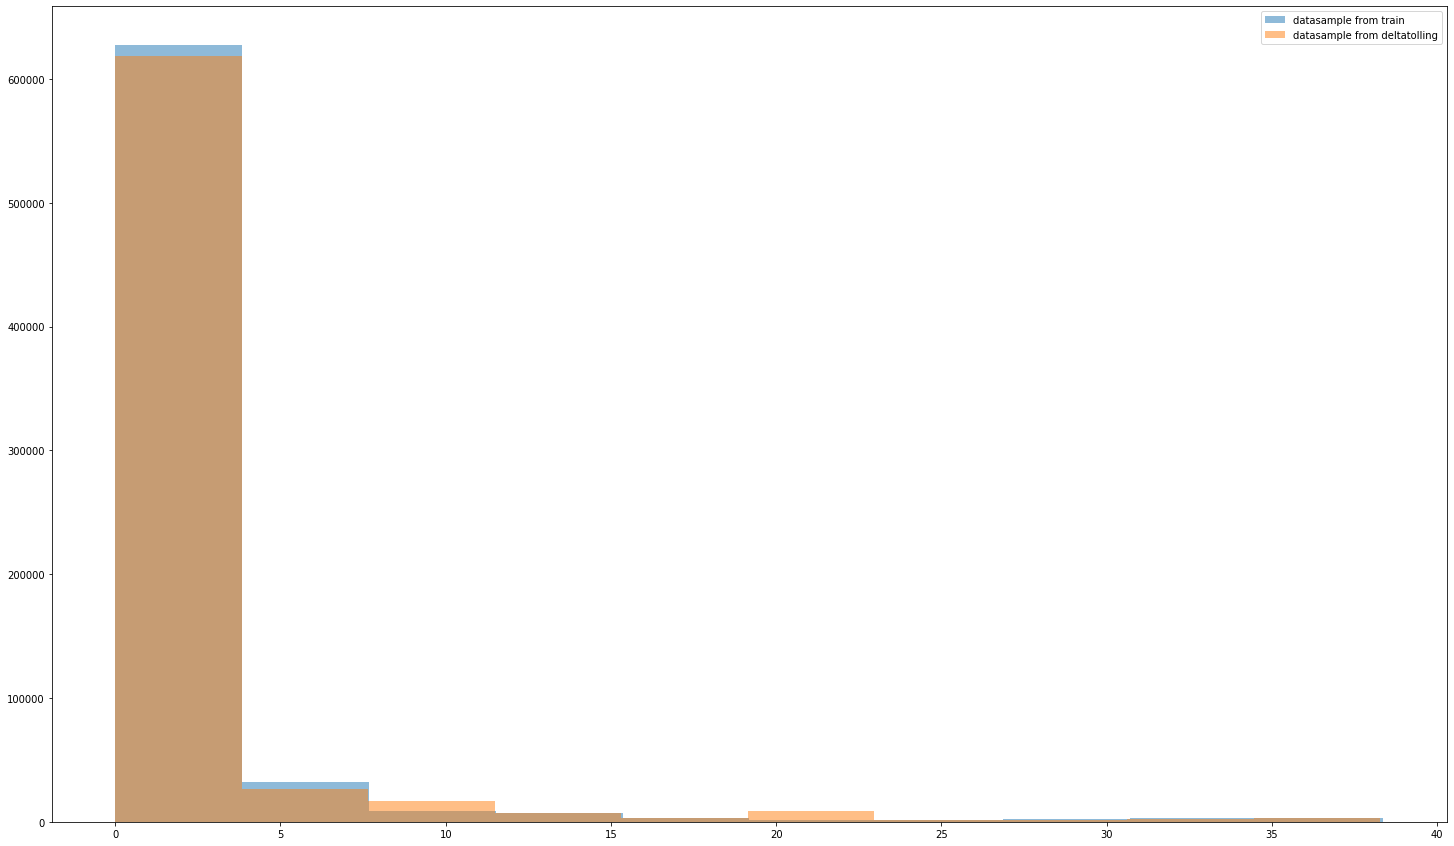

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,15))
plt.hist(neg_reward_batch.flatten(), alpha = 0.5, label='datasample from train')
plt.hist(reward.flatten(), alpha = 0.5, label='datasample from deltatolling')
plt.legend()
plt.show()

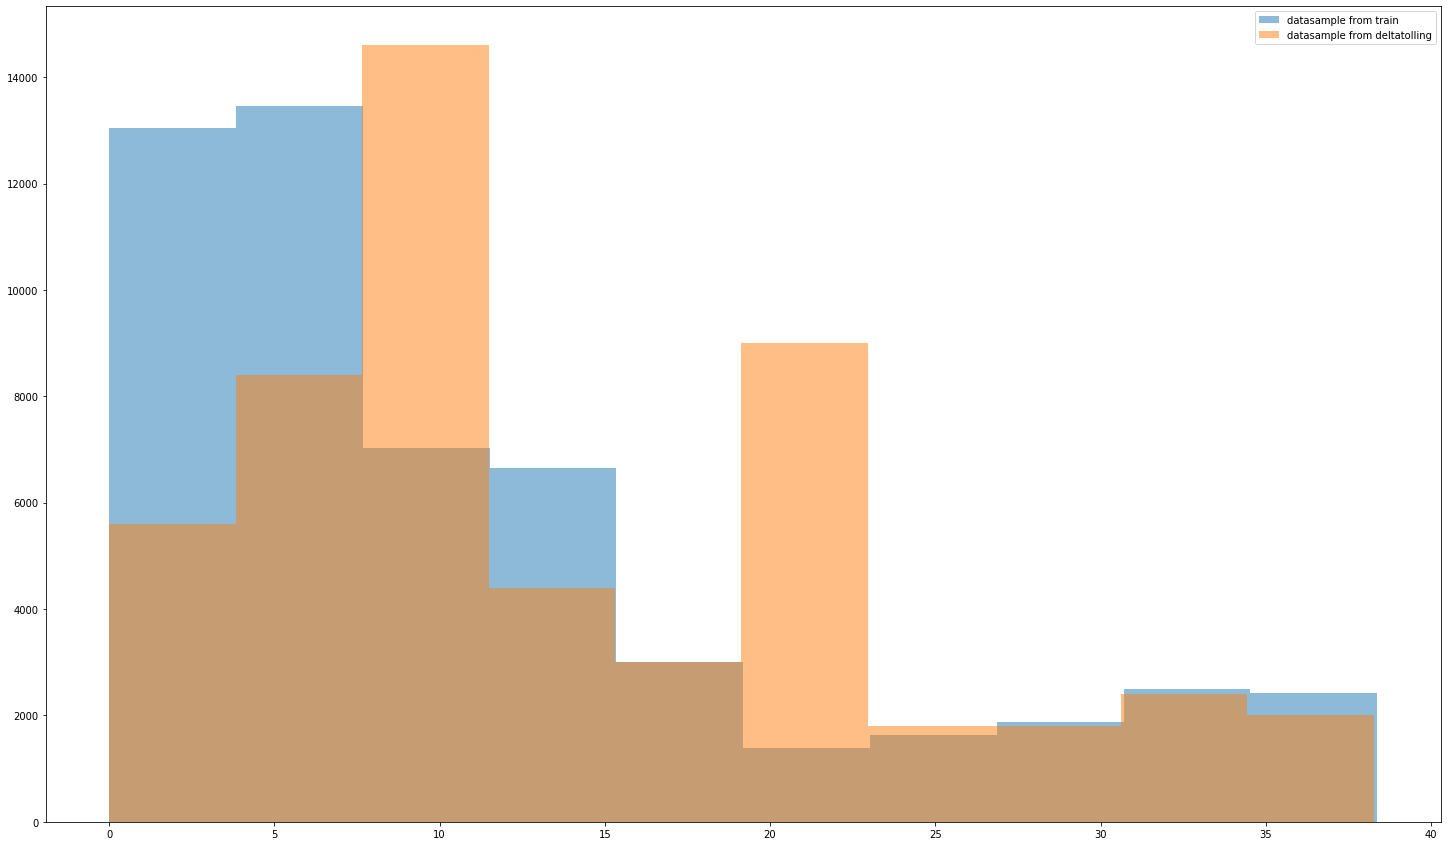

In [10]:
train_movement = [54, 55, 58, 66, 70, 74, 82, 100, 112, 124, 142, 154, 166, 184, 196, 208, 226, 238, 250, 268, 280, 292, 310, 322, 334, 352, 364, 376, 394, 406, 418, 436, 448, 460, 478, 490, 502, 520, 532, 544, 562, 563, 574, 575, 586, 587, 601, 605, 613, 616, 627, 642, 674]
train_id = np.array(train_movement)
plt.figure(figsize=(25,15))
# (1000, 690, 1)
plt.hist(neg_reward_batch[:, train_id, :].flatten(), alpha = 0.5, label='datasample from train')
plt.hist(reward[:, train_id, :].flatten(), alpha = 0.5, label='datasample from deltatolling')
plt.legend()
plt.show()

In [11]:
len(train_movement)

53

In [13]:
from actor_critic.last_agent import Last_Agent
from actor_critic.replay_memory import AgentReplayMemory

memory = AgentReplayMemory(2000, 690, state_dim=1)
memory.buffer['state'] = state
memory.buffer['next_state'] = next_state
memory.buffer['reward'] = reward
memory.buffer['action'] = action
memory.buffer['done'] = np.zeros((2000, 690, 1))
memory._size = len(state)

In [18]:
import gym
from world import World
import argparse
parser = argparse.ArgumentParser(description="QD Actor-Critic Args")
parser.add_argument(
    "--gamma",
    type=float,
    default=0,
    metavar="G",
    help="discount factor for reward (default: 0.99)",
)
parser.add_argument(
    "--tau",
    type=float,
    default=0.125,
    metavar="G",
    help="target smoothing coefficient(τ) (default: 0.125)",
)
parser.add_argument(
    "--alpha",
    type=float,
    default=0,
    metavar="G",
    help="Temperature parameter α determines the relative importance of the entropy\
                    term against the reward (default: 0.2)",
)
parser.add_argument(
    "--lr",
    type=float,
    default=0.001,
    metavar="G",
    help="learning rate (default: 0.001)",
)
parser.add_argument(
    "--batch_size", type=int, default=2000, metavar="N", help="batch size (default: 32)"
)
parser.add_argument(
    "--thread", type=int, default=8, help="number of threads (default: 8)"
)
parser.add_argument(
    "--target_update_interval",
    type=int,
    default=1,
    metavar="N",
    help="Value target update per no. of updates per step (default: 240)[spinning up update target every update]",
)
parser.add_argument("--config_file", type=str, help="path of config file")
args = parser.parse_args(args=["--config_file", "dataset/manual_16x3/config_undir.json"])
world = World(args.config_file, thread_num=args.thread, args=args)
agent_action_space = gym.spaces.Box(np.array([-1]), np.array([1]))
agent = Last_Agent(agent_action_space, 690, 1, world, args)

building world...
creating intersections...
intersections created.
parsing roads...
world built.


In [23]:
from torch.utils.tensorboard import SummaryWriter
import torch
writer = SummaryWriter('tensorboard/train_from_memory')
for i in range(500):
    critic_loss, policy_loss = agent.update_parameters(memory, memory._size, i)
    writer.add_scalar('local_critic_loss', critic_loss, i)
    writer.add_scalar('policy_loss', policy_loss, i)
dir_name = 'model/train_from_memory/'
for id, ply in enumerate(agent.policy):
    torch.save(ply.state_dict(), dir_name + 'policy{}.pth'.format(id))

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model(torch.nn.Module):
    def __init__(self, state_dim, action_dim=1):
        super(model, self).__init__()
        # Q1 architecture
        self.linear1 = nn.Linear(state_dim, 64)
        self.linear2 = nn.Linear(action_dim, 16)
        self.linear3 = nn.Linear(80, 32)
        self.lineara = nn.Linear(32, 32)
        self.linear4 = nn.Linear(32, 1)

        # Q2 architecture
        self.linear5 = nn.Linear(state_dim, 64)
        self.linear6 = nn.Linear(action_dim, 16)
        self.linear7 = nn.Linear(80, 32)
        self.linearb = nn.Linear(32, 32)
        self.linear8 = nn.Linear(32, 1)

    def forward(self, state, action):
        x_s1 = F.sigmoid(self.linear1(state))
        x_a1 = F.sigmoid(self.linear2(action))
        x = torch.cat([x_s1, x_a1], axis=1)
        x1 = F.sigmoid(self.linear3(x))
        x1 = F.sigmoid(self.lineara(x1))
        x1 = self.linear4(x1)

        x_s2 = F.sigmoid(self.linear5(state))
        x_a2 = F.sigmoid(self.linear6(action))
        x = torch.cat([x_s2, x_a2], axis=1)
        x2 = F.sigmoid(self.linear7(x))
        x2 = F.sigmoid(self.linearb(x2))
        x2 = self.linear8(x2)

        return x1, x2

In [89]:
from actor_critic.model import AgentQNet, ActorNet
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from actor_critic.utils import soft_update, hard_update

gamma = 0
alpha = 0
tau = 0.125
state_dim = 10
action_dim = 1
lr = 0.005
critic = model(state_dim, action_dim)
critic_optim = Adam(critic.parameters(), lr=lr)
critic_target = model(state_dim, action_dim)
policy = ActorNet(state_dim)
policy_optim = Adam(policy.parameters(), lr=lr)
hard_update(critic_target, critic)

In [96]:
import numpy as np
dir_name = 'datasample/manual_16x3/anon_16_3_newyork_real/share-sac/0.99/'
state_batch = np.load(file=dir_name + 'state.npy').reshape(-1, 10)
next_state_batch = np.load(file=dir_name + 'next_state.npy').reshape(-1, 10)
action_batch = np.load(file=dir_name + 'action.npy').reshape(-1, 1)
reward_batch = np.load(file=dir_name + 'reward.npy').reshape(-1, 1)

In [104]:
# 不平衡采样
reward_sample = {i:[] for i in range(20)}
bins = [(-3.0 + j * 0.3) for j in range(21)]

In [105]:
bins

[-3.0,
 -2.7,
 -2.4,
 -2.1,
 -1.8,
 -1.5,
 -1.2000000000000002,
 -0.8999999999999999,
 -0.6000000000000001,
 -0.30000000000000027,
 0.0,
 0.2999999999999998,
 0.5999999999999996,
 0.8999999999999999,
 1.2000000000000002,
 1.5,
 1.7999999999999998,
 2.0999999999999996,
 2.3999999999999995,
 2.7,
 3.0]

In [109]:
for idx, rwd in enumerate(reward_batch):
    for j in range(20):
        if rwd[0] > bins[j] and rwd[0] <= bins[j + 1]:
            reward_sample[j].append(idx)
            break

In [111]:
from random import choice
sample_idx = []
for i in range(1000):
    for key, value in reward_sample.items():
        if value != []:
            sample_idx.append(choice(value))

In [117]:
import numpy as np
sample_idx = np.array(sample_idx)
dir_name = 'datasample/manual_16x3/anon_16_3_newyork_real/share-sac/0.99/'
state_batch = np.load(file=dir_name + 'state.npy').reshape(-1, 10)
next_state_batch = np.load(file=dir_name + 'next_state.npy').reshape(-1, 10)
action_batch = np.load(file=dir_name + 'action.npy').reshape(-1, 1)
reward_batch = np.load(file=dir_name + 'reward.npy').reshape(-1, 1)

In [118]:
state_batch = state_batch[sample_idx]
next_state_batch = next_state_batch[sample_idx]
action_batch = action_batch[sample_idx]
reward_batch = reward_batch[sample_idx]

In [119]:
reward_batch.shape

(19000, 1)

No handles with labels found to put in legend.


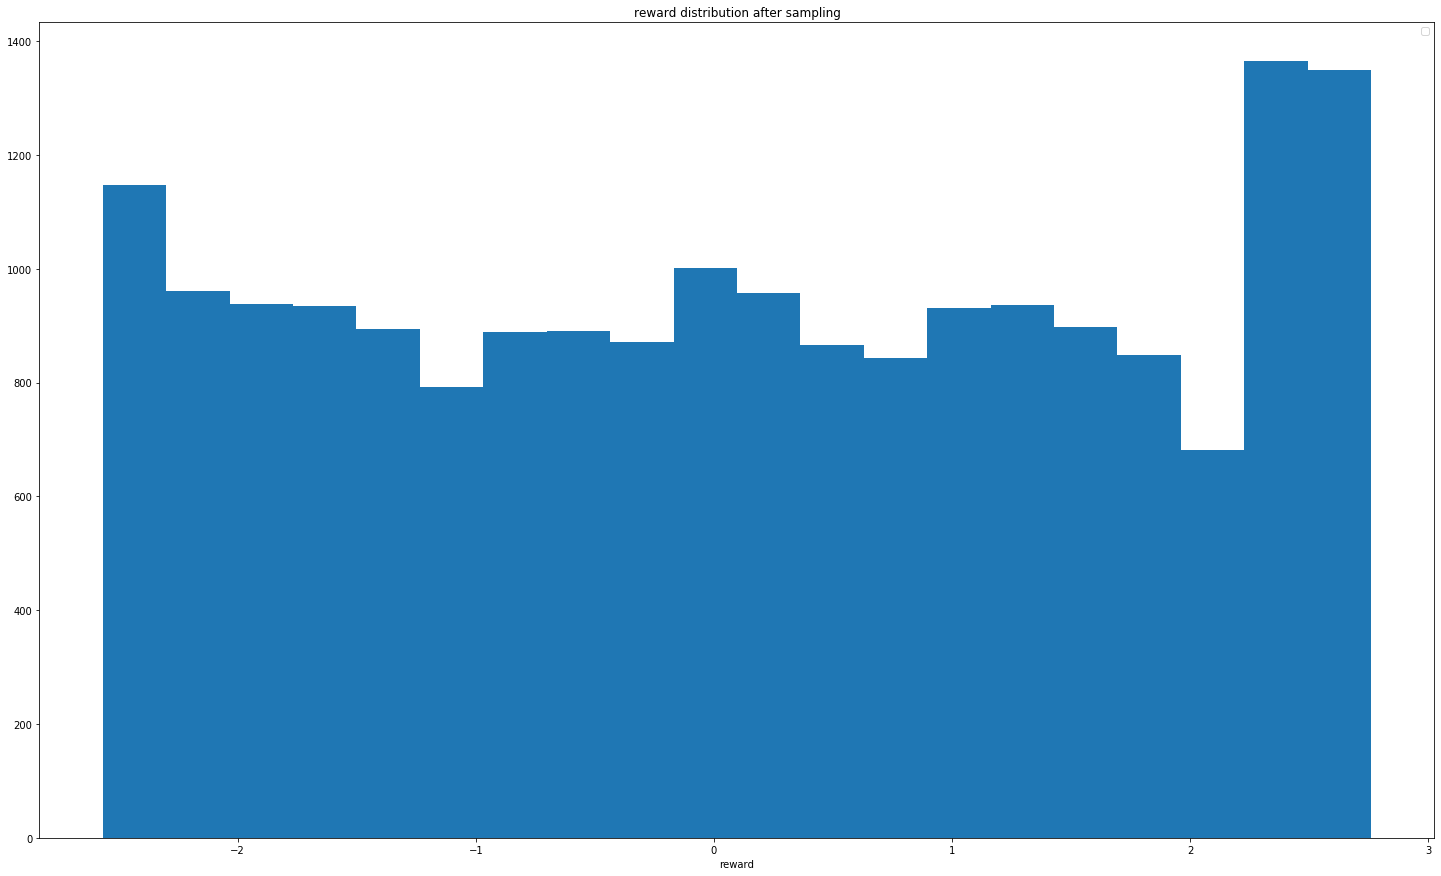

In [114]:
import matplotlib.pyplot as plt
import numpy as np
reward = reward_batch.flatten()[np.array(sample_idx)]
plt.figure(figsize=(25,15))
plt.title("reward distribution after sampling")
plt.xlabel("reward")
plt.hist(reward, 20)
plt.legend()

分割线
以上有不平衡采样

In [99]:
len(reward_batch)
print(max(reward_batch))
print(min(reward_batch))

[2.75974142]
[-2.56659618]


No handles with labels found to put in legend.


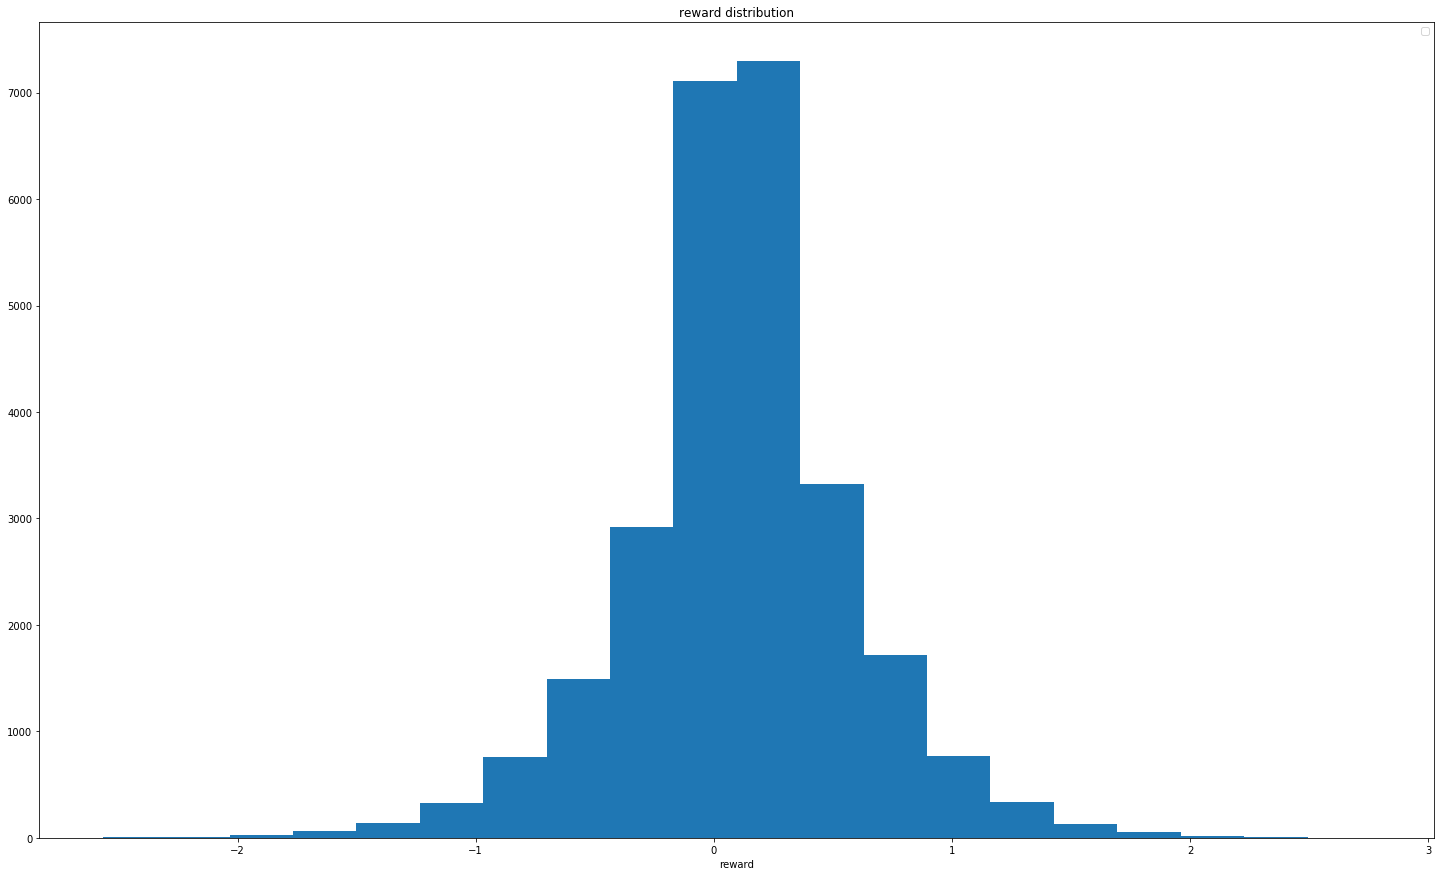

In [98]:
import matplotlib.pyplot as plt
reward = reward_batch.flatten()
plt.figure(figsize=(25,15))
plt.title("reward distribution")
plt.xlabel("reward")
plt.hist(reward, 20)
plt.legend()

In [121]:
def update_param():
    with torch.no_grad():
        next_state_action, next_state_log_pi = policy.sample(next_state_batch)
        next_state_action = torch.FloatTensor(next_state_action)
        qf1_next_target, qf2_next_target = critic_target(
            next_state_batch, next_state_action
        )
        min_qf_next_target = (
            torch.min(qf1_next_target, qf2_next_target)
            - alpha * next_state_log_pi
        )
        next_q_value = reward_batch + gamma * (min_qf_next_target)

    qf1, qf2 = critic(
        state_batch, action_batch
    )  # Two Q-functions to mitigate positive bias in the policy improvement step
    qf1_loss = F.mse_loss(
        qf1, next_q_value
    )  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
    qf2_loss = F.mse_loss(
        qf2, next_q_value
    )  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
    qf_loss = qf1_loss + qf2_loss

    critic_optim.zero_grad()
    qf_loss.backward()
    critic_optim.step()

    # 更新policy网络

    pi, log_pi = policy.sample(state_batch)
    pi = torch.FloatTensor(pi)

    qf1_pi, qf2_pi = critic(state_batch, pi)
    min_qf_pi = torch.min(qf1_pi, qf2_pi)

    policy_loss = (
        (alpha * log_pi) - min_qf_pi
    ).mean()  # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

    policy_optim.zero_grad()
    policy_loss.backward()
    policy_optim.step()

    # if updates % self.target_update_interval == 0:
    soft_update(critic_target, critic, tau)

    return qf_loss.item(), policy_loss.item()

In [122]:
state_batch = torch.FloatTensor(state_batch)
next_state_batch = torch.FloatTensor(next_state_batch)
action_batch = torch.FloatTensor(action_batch)
reward_batch = torch.FloatTensor(reward_batch)

In [123]:
action_batch.shape

torch.Size([19000, 1])

In [124]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('log/tensorboard/train_from_memory(sampling)')
for epoch in range(5000):
    critic_loss, policy_loss = update_param()
    print('epoch: ', epoch,' critic_loss: ', critic_loss, "| policy_loss: ", policy_loss)
    writer.add_scalar('critic_loss', critic_loss, epoch)
    writer.add_scalar('policy_loss', policy_loss, epoch)  

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:  0  critic_loss:  3.908029079437256 | policy_loss:  -0.3031799793243408
epoch:  1  critic_loss:  3.339717149734497 | policy_loss:  0.22940683364868164
epoch:  2  critic_loss:  3.094203233718872 | policy_loss:  -0.49949347972869873
epoch:  3  critic_loss:  3.1477749347686768 | policy_loss:  -0.10012416541576385
epoch:  4  critic_loss:  2.8886942863464355 | policy_loss:  0.02829837240278721
epoch:  5  critic_loss:  2.914372444152832 | policy_loss:  -0.4579419791698456
epoch:  6  critic_loss:  2.738109588623047 | policy_loss:  -0.2734166979789734
epoch:  7  critic_loss:  2.5895872116088867 | policy_loss:  -0.05351846292614937
epoch:  8  critic_loss:  2.5247063636779785 | policy_loss:  -0.1512182056903839
epoch:  9  critic_loss:  2.416409969329834 | policy_loss:  -0.22736641764640808
epoch:  10  critic_loss:  2.4118359088897705 | policy_loss:  -0.1942567080259323
epoch:  11  critic_loss:  2.3361096382141113 | policy_loss:  -0.0026685509365051985
epoch:  12  critic_loss:  2.316491127

训练policy

In [46]:
import torch
from actor_critic.model import AgentQNet, ActorNet
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam

gamma = 0
alpha = 0
tau = 0.125
state_dim = 10
action_dim = 1
lr = 0.005
policy = ActorNet(state_dim)
policy_optim = Adam(policy.parameters(), lr=lr)

PATH = 'model/manual_16x3/anon_16_3_newyork_real/share-sac/50/120/critic.pth'
critic = AgentQNet(10, 1)
critic.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [47]:
import numpy as np
dir_name = 'datasample/manual_16x3/anon_16_3_newyork_real/share-sac/0.0/'
state_batch = np.load(file=dir_name + 'state.npy').reshape(-1, 10)
next_state_batch = np.load(file=dir_name + 'next_state.npy').reshape(-1, 10)
action_batch = np.load(file=dir_name + 'action.npy').reshape(-1, 1)
reward_batch = np.load(file=dir_name + 'reward.npy').reshape(-1, 1)

In [48]:
def update_policy():
    # 更新policy网络

    pi, log_pi = policy.sample(state_batch)
    pi = torch.FloatTensor(pi)

    qf1_pi, qf2_pi = critic(state_batch, pi)
    min_qf_pi = torch.min(qf1_pi, qf2_pi)

    policy_loss = (
        (alpha * log_pi) - min_qf_pi
    ).mean()  # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

    policy_optim.zero_grad()
    policy_loss.backward()
    policy_optim.step()

    return policy_loss.item()

In [49]:
state_batch = torch.FloatTensor(state_batch)
next_state_batch = torch.FloatTensor(next_state_batch)
action_batch = torch.FloatTensor(action_batch)
reward_batch = torch.FloatTensor(reward_batch)

In [50]:
from torch.utils.tensorboard import SummaryWriter
import os
writer = SummaryWriter('log/tensorboard/train_policy/120')
for epoch in range(2000):
    policy_loss = update_policy()
    print('epoch: ', epoch, "| policy_loss: ", policy_loss)
    writer.add_scalar('policy_loss', policy_loss, epoch)
dir_name = 'model/policy/120/'
if not os.path.isdir(dir_name):
    os.makedirs(dir_name)
torch.save(policy.state_dict(), dir_name + 'policy.pth')

epoch:  0 | policy_loss:  -0.09406884759664536
epoch:  1 | policy_loss:  -0.09482041746377945
epoch:  2 | policy_loss:  -0.09560216963291168
epoch:  3 | policy_loss:  -0.0963275134563446
epoch:  4 | policy_loss:  -0.09723352640867233
epoch:  5 | policy_loss:  -0.09800192713737488
epoch:  6 | policy_loss:  -0.09869556874036789
epoch:  7 | policy_loss:  -0.09928643703460693
epoch:  8 | policy_loss:  -0.09982729703187943
epoch:  9 | policy_loss:  -0.1002352386713028
epoch:  10 | policy_loss:  -0.10052545368671417
epoch:  11 | policy_loss:  -0.10077697783708572
epoch:  12 | policy_loss:  -0.10093408077955246
epoch:  13 | policy_loss:  -0.10107742249965668
epoch:  14 | policy_loss:  -0.10118355602025986
epoch:  15 | policy_loss:  -0.10124797374010086
epoch:  16 | policy_loss:  -0.10129277408123016
epoch:  17 | policy_loss:  -0.10133904218673706
epoch:  18 | policy_loss:  -0.10136551409959793
epoch:  19 | policy_loss:  -0.10138338059186935
epoch:  20 | policy_loss:  -0.10139956325292587
epoc